# linear filter

## Gaussian Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gaussian_kernel(radius, sigma):
	ksize = 2 * radius + 1
	ax = np.linspace(-radius, radius, ksize)
	xx, yy = np.meshgrid(ax, ax)

	kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
	kernel /= np.sum(kernel)

	return kernel

def gaussian_1d_kernel(radius, sigma):
	ksize = 2 * radius + 1
	ax = np.linspace(-radius, radius, ksize)

	kernel_1d = np.exp(-(ax ** 2) / (2. * sigma ** 2))
	kernel_1d /= np.sum(kernel_1d)

	return kernel_1d

In [3]:
kernel = gaussian_kernel(radius=2, sigma=1.0)
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


In [4]:
kernel_h = gaussian_1d_kernel(radius=2, sigma=1.0)
kernel_v = kernel_h.reshape(-1, 1)
kernel2d = kernel_v @ kernel_h.reshape(1,-1)

kernel2d_direct = gaussian_kernel(radius=2, sigma=1.0)

print(np.allclose(kernel2d, kernel2d_direct, atol=1e-6))

True


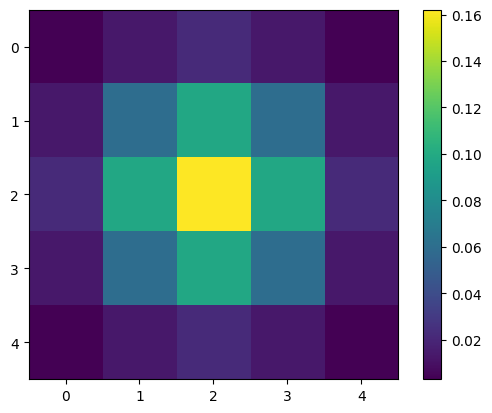

In [5]:
img = plt.imshow(kernel, cmap='viridis', interpolation='none')
plt.colorbar(img)
plt.show()

In [6]:
kernel = gaussian_kernel(radius=1, sigma=0.3)
print(kernel)

[[1.47168816e-05 3.80682504e-03 1.47168816e-05]
 [3.80682504e-03 9.84713832e-01 3.80682504e-03]
 [1.47168816e-05 3.80682504e-03 1.47168816e-05]]


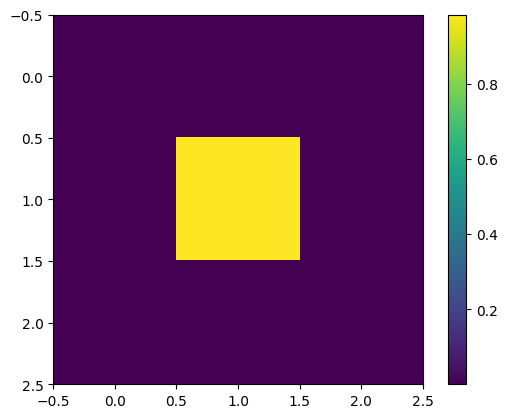

In [7]:
img = plt.imshow(kernel, cmap='viridis', interpolation='none')
plt.colorbar(img)
plt.show()

In [8]:
def linear_filter_2d_seperate(image: np.ndarray, kernel_h: np.ndarray, kernel_v: np.ndarray) -> np.ndarray:
    k_h = kernel_h.shape[0]
    k_v = kernel_v.shape[0]

    if image.ndim == 2:
        h, w = image.shape
        channels = 1
    elif image.ndim == 3:
        h, w, channels = image.shape
    else:
        raise ValueError("image dim error!!!")
    
    pad_h = k_h // 2
    pad_v = k_v // 2

    if channels == 1:
        padded_h = np.pad(image, ((0, 0), (pad_h, pad_h)), mode='constant', constant_values=0)
        temp = np.zeros_like(image, dtype=np.float32)

        for i in range(h):
            for j in range(w):
                region = padded_h[i, j:j+k_h]
                temp[i, j] = np.sum(region * kernel_h)
        
        padded_v = np.pad(temp, ((pad_v, pad_v), (0, 0)), mode='constant', constant_values=0)
        output = np.zeros_like(image, dtype=np.float32)

        for i in range(h):
            for j in range(w):
                region = padded_v[i:i+k_v, j]
                output[i, j] = np.sum(region * kernel_v)
    else:
        padded_h = np.pad(image, ((0, 0), (pad_h, pad_h), (0, 0)), mode='constant', constant_values=0)
        temp = np.zeros_like(image, dtype=np.float32)

        for i in range(h):
            for j in range(w):
                for c in range(channels):
                    region = padded_h[i, j:j+k_h, c]
                    temp[i, j, c] = np.sum(region * kernel_h)
            
        padded_v = np.pad(temp, ((pad_v, pad_v), (0, 0), (0, 0)), mode='constant', constant_values=0)
        output = np.zeros_like(image, dtype=np.float32)

        for i in range(h):
            for j in range(w):
                for c in range(channels):
                    region = padded_v[i:i+k_v, j, c]
                    output[i, j, c] = np.sum(region * kernel_v)
                
    output = np.clip(output, 0, 255)
    if output.shape[2] == 1:
        output = output[:, :, 0]
    return output.astype(np.uint8)

In [9]:
def linear_filter_2d(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    kernel = np.flipud(np.fliplr(kernel))
    k_h, k_w = kernel.shape

    if image.ndim == 2:
        h, w = image.shape
        channels = 1
    elif image.ndim == 3:
        h, w, channels = image.shape
    else:
        raise ValueError("image dim error!!!")
    
    pad_h = k_h // 2
    pad_w = k_w // 2

    if channels == 1:
        padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
        output = np.zeros_like(image, dtype=np.float32)

        for i in range(h):
            for j in range(w):
                region = padded[i:i+k_h, j:j+k_w]
                output[i, j] = np.sum(region * kernel)
    else:
        padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=0)
        output = np.zeros_like(image, dtype=np.float32)

        for c in range(channels):
            for i in range(h):
                for j in range(w):
                    region = padded[i:i+k_h, j:j+k_w, c]
                    output[i, j, c] = np.sum(region * kernel)
                
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

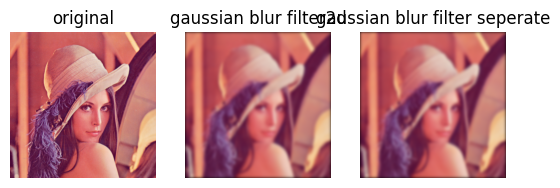

In [11]:
import cv2
import numpy as np

image_bgr = cv2.imread('../test/Lenna.png')

if image_bgr is None:
    raise FileNotFoundError("image read fail!")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

blur_kernel = gaussian_kernel(15, 5.0)
result_filter2d = linear_filter_2d(image_rgb, blur_kernel)

blur_kernel_h = gaussian_1d_kernel(15, 5.0)
blur_kernel_v = gaussian_1d_kernel(15, 5.0)
result_filter_seperate = linear_filter_2d_seperate(image_rgb, blur_kernel_h, blur_kernel_v)

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(result_filter2d)
plt.title("gaussian blur filter2d")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_filter_seperate)
plt.title("gaussian blur filter seperate")
plt.axis('off')

plt.show()

In [12]:
print(np.allclose(result_filter2d, result_filter_seperate, atol=1e-6))

True
